## Comparing Agents List:

###### 1. Single Action Agent
Always returns the same action / product id.

###### 2. Random Action Agent
The Agent returns the random action from all of product id's range.

###### 3. Organic Product Count Agent
The Agent that selects an action based on the most frequently viewed Product.

###### 4. Organic Per User Count Agent
The Agent that counts organic views of products per a user and selects an action for the most frequently shown product.

###### 5. Define Organic MF Agent
The Agent that selects an action from the model that performs Organic Events matrix factorisation.

###### 6. Bandit Click Count Agent
The Agent that selects an Action for the most frequently clicked bandit action before.

###### 7. Bandit MF Agent - used Matrix Factorization learning model
The Agent chooses maximum logit (logistic regression) from all possible actions.

###### 8. Likelihood Agent
Act method returns an action based on current observation and past history.

## Environment Setup

In [1]:
from copy import deepcopy

import recogym
from my_agent_utils import add_agent_id, combine_stat
from my_entries.likehood_agent import LikelihoodAgent, CountFeatureProvider
from single_action_agent import SingleActionAgent
%matplotlib inline
import gym
import matplotlib.pyplot as plt

from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args, OrganicCount, organic_count_args, \
    OrganicMFSquare, organic_mf_square_args, BanditCount, bandit_count_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import plot_verify_agents, verify_agents

# Set style for pretty plots
plt.style.use('ggplot')

products = 10

offline_users = 1000
online_users = 200

# You can overwrite environment arguments here:

env_1_args['random_seed'] = 42
env_1_args['num_products']= products
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=1

# env_1_args['sigma_mu_organic'] = 0.0
# env_1_args['sigma_omega']=0
# env_1_args['normalize_beta']=True

# Initialize the gym for the first time by calling .make() and .init_gym()

#---------------------------------------------
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

env_1_args['number_of_flips'] = 0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega'] = 1
env_1_args['random_seed'] = 42
env_1_args['num_products'] = products
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 5
#---------------------------------------------

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()


/workspace/ML/reco-gym/recogym/envs/abstract.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


1. Define Single Action Agent

In [2]:
single_action_agent = SingleActionAgent(Configuration({**env_1_args,}))

SingleActionAgent %%%% num_products: 10


2. Define Random Action Agent

In [3]:
random_agent = RandomAgent(Configuration({**random_args,**env_1_args,}))

RandomAgent %%%% num_products: 10


3. Define Organic Product Count Agent

In [4]:
organic_count_agent = OrganicCount(Configuration({**organic_count_args,**env_1_args,}))

4. Define Organic Per User Count Agent

In [5]:
organic_user_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args, **env_1_args, 'select_randomly': True,}))

5. Define Organic MF Agent

In [6]:
organic_mf_agent = OrganicMFSquare(Configuration({**organic_mf_square_args, **env_1_args, 'select_randomly': True,}))

6. Define Bandit Click Count Agent

In [7]:
bandit_count_agent = BanditCount(Configuration({**bandit_count_args,**env_1_args,}))

BanditCount %%%% num_products: 10


7. Define Bandit MF Agent

In [8]:
bandit_mf_square_agent = BanditMFSquare(Configuration({ **bandit_mf_square_args, **env_1_args,}))

8. Define Likelihood Agent

In [9]:
from scipy.stats import beta
import pandas as pd

config = Configuration(env_1_args)

count_product_views_feature_provider = CountFeatureProvider(config)

likelihood_agent = LikelihoodAgent(count_product_views_feature_provider)

lh_data = deepcopy(env).generate_logs(offline_users)

likelihood_agent.train(lh_data)

bandits = lh_data[lh_data['z'] == 'bandit']
successes = bandits[bandits['c'] == 1].shape[0]
failures = bandits[bandits['c'] == 0].shape[0]

lh_agent_res = add_agent_id(
    'Likelihood',
    beta.ppf(0.025, successes + 1, failures + 1),
    beta.ppf(0.500, successes + 1, failures + 1),
    beta.ppf(0.975, successes + 1, failures + 1))


Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/1000 [00:00<?, ?it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT None
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 1000/1000 [00:18<00:00, 54.60it/s]



LikelihoodAgent train() num_products 10

run model.fit rewards size 75890


In [10]:
pd.DataFrame().from_dict(lh_agent_res)

,Agent,0.025,0.500,0.975
0,Likelihood,0.011497,0.012263,0.013063


## A/B-Test Evaluation

In [11]:
result_bandit_mf_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Bandit MF Agent': bandit_mf_square_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 3/200 [00:00<00:08, 22.32it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT BanditMFSquare(
  (product_embedding): Embedding(10, 5)
  (user_embedding): Embedding(10, 5)
)
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:05<00:00, 38.84it/s]


In [12]:
result_single_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Single Action Agent': single_action_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/200 [00:00<?, ?it/s]/workspace/ML/reco-gym/single_action_agent.py:40: RuntimeWarning: invalid value encountered in true_divide
  prob = self.organic_views / sum(self.organic_views)
Users:   2%|▏         | 4/200 [00:00<00:05, 37.55it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <single_action_agent.SingleActionAgent object at 0x110ae0250>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


In [13]:
result_random_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Random Agent': random_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   2%|▎         | 5/200 [00:00<00:04, 45.68it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.random_agent.RandomAgent object at 0x13c29dfd0>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 58.87it/s]


In [14]:
result_organic_count_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Organic Count Agent': organic_count_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   4%|▍         | 8/200 [00:00<00:03, 58.51it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.organic_count.OrganicCount object at 0x13bc672d0>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 65.56it/s]


In [15]:
result_organic_user_counter_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Organic Count per User Agent': organic_user_counter_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 3/200 [00:00<00:07, 27.31it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.organic_user_count.OrganicUserEventCounterAgent object at 0x13bdfcd10>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:04<00:00, 46.96it/s]


In [16]:
result_organic_mf_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Organic MF Agent': organic_mf_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   4%|▎         | 7/200 [00:00<00:02, 67.25it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT OrganicMFSquare(
  (product_embedding): Embedding(10, 5)
  (output_layer): Linear(in_features=5, out_features=10, bias=True)
)
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 58.23it/s]


In [17]:

result_bandit_count_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Bandit Count Agent': bandit_count_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   4%|▎         | 7/200 [00:00<00:02, 69.52it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.bandit_count.BanditCount object at 0x13c362cd0>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 63.40it/s]


In [18]:
result_likelihood_id = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        'Likelihood LogReg': likelihood_agent,
    }
)


Organic Users: 0it [00:00, ?it/s]
Users:   1%|          | 2/200 [00:00<00:14, 13.77it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <my_entries.likehood_agent.LikelihoodAgent object at 0x13bc67cd0>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:05<00:00, 34.19it/s]


In [19]:
comb_result = combine_stat([
                            result_single_id,
                            result_random_id,
                            result_organic_count_id,
                            result_organic_user_counter_id,
                            result_organic_mf_id,
                            result_bandit_mf_id,
                            result_likelihood_id
                            ])


===>                  Agent    0.025     0.500     0.975
0  Single Action Agent  0.01028  0.011927  0.013739
===>           Agent     0.025     0.500     0.975
0  Random Agent  0.010314  0.012008  0.013876
===>                  Agent    0.025     0.500     0.975
0  Organic Count Agent  0.00949  0.011119  0.012921
===>                           Agent     0.025     0.500     0.975
0  Organic Count per User Agent  0.013718  0.015641  0.017733
===>               Agent     0.025     0.500     0.975
0  Organic MF Agent  0.013372  0.015274  0.017346
===>              Agent     0.025     0.500     0.975
0  Bandit MF Agent  0.009783  0.011461  0.013319
===>                Agent     0.025     0.500     0.975
0  Likelihood LogReg  0.015802  0.017872  0.020112


In [20]:
comb_result

,Agent,0.025,0.500,0.975
0,Single Action Agent,0.010280,0.011927,0.013739
1,Random Agent,0.010314,0.012008,0.013876
2,Organic Count Agent,0.009490,0.011119,0.012921
3,Organic Count per User Agent,0.013718,0.015641,0.017733
4,Organic MF Agent,0.013372,0.015274,0.017346
5,Bandit MF Agent,0.009783,0.011461,0.013319
6,Likelihood LogReg,0.015802,0.017872,0.020112


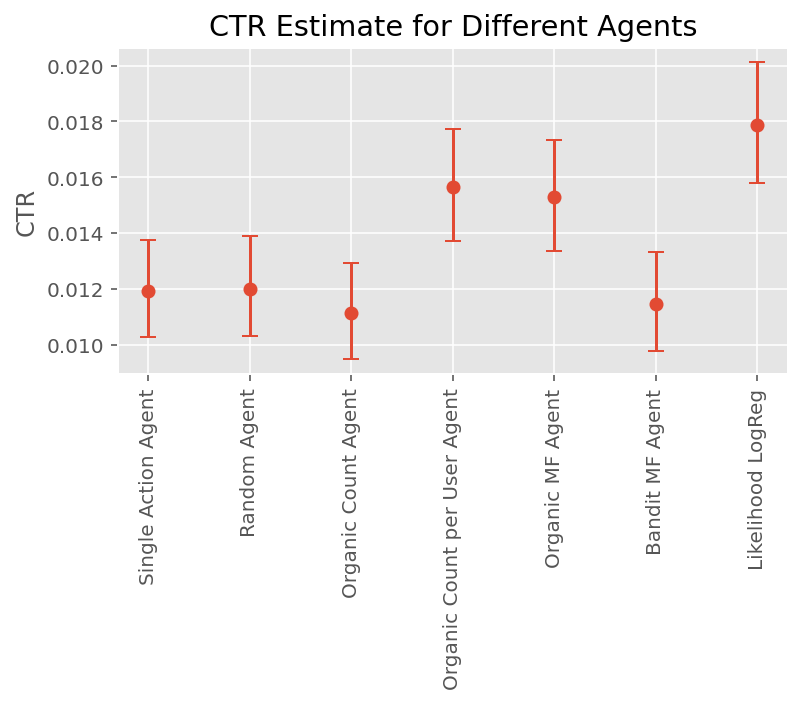

In [21]:
fig = plot_verify_agents(comb_result)
plt.ylabel('CTR')
plt.show()




